In [1]:
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

import clmm
import numpy as np
from numpy import random
from clmm import Cosmology
# from clmm.support import mock_data as mock
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt

# plt.rcParams['text.latex.preamble'] = [r'\usepackage{pxfonts, mathpazo}']
plt.rc('text', usetex=True)

In [2]:
np.random.seed(0)
# Define cosmological parameters
cosmo_clmm = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
sigma_g       = 5e-2  # True ellipticity standard variation
sigma_z       = 5e-2
ndata         = 1000
scale         = 1e-2

In [3]:
cosmo = Nc.HICosmo.new_from_name(Nc.HICosmo, "NcHICosmoLCDM")
dp    = Nc.HaloDensityProfileNFW.new(Nc.HaloDensityProfileMassDef.CRITICAL, 200)
dist  = Nc.Distance.new(6)

dist.prepare(cosmo)

smd = Nc.WLSurfaceMassDensity.new(dist)
rng = Ncm.RNG.seeded_new("mt19937", 1)

gsdp  = Nc.GalaxySDPositionSRDY1()
gsdzp = Nc.GalaxySDZProxyGauss()
gsds  = Nc.GalaxySDShapeGauss()

gsdp.set_r_lim(Ncm.Vector.new_array([1e-6, 6]))
gsdp.set_z_lim(Ncm.Vector.new_array([1e-6, 4.5]))
gsdzp.set_z_lim(Ncm.Vector.new_array([1e-6, 4.5]))
gsdzp.set_sigma(sigma_z)
gsds.set_sigma(sigma_g)

gwll = Nc.GalaxyWLLikelihood(s_dist=gsds, zp_dist=gsdzp, rz_dist=gsdp)

obs_matrix = Ncm.Matrix.new(ngals, 3)

for i in range(ngals):
    obs = gwll.gen(cosmo, dp, smd, cluster_z, rng)
    for j in range(3):
        obs_matrix.set(i, j, obs.get(j))
    #     print(j, obs.get(j))
    # print('')

gwll.set_obs (obs_matrix)
gwll.set_ndata (ndata)
gwll.set_cut (3.0, 5.0)

In [4]:
ga = Ncm.ObjArray.new ()
ga.add (gwll)

dcwll = Nc.DataClusterWLL (galaxy_array=ga, z_cluster=cluster_z)
dcwll.set_init (True)

moo = clmm.Modeling (massdef='critical', delta_mdef=200, halo_profile_model='nfw')
moo.set_cosmo(cosmo_clmm)
mset = moo.get_mset ()

MDelta_pi = mset.param_get_by_full_name ("NcHaloDensityProfile:log10MDelta")
cDelta_pi = mset.param_get_by_full_name ("NcHaloDensityProfile:cDelta")

mset.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FREE)
mset.prepare_fparam_map ()

dset = Ncm.Dataset.new ()
dset.append_data (dcwll)
lh = Ncm.Likelihood.new (dset)
fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)

In [5]:
fit.run (Ncm.FitRunMsgs.SIMPLE)
fit.obs_fisher ()
fit.log_info ()
fit.log_covar ()

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#.............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:09.0249430
#  iteration            [000043]
#  function evaluations [000045]
#  gradient evaluations [000000]
#  degrees of freedom   [009998]
#  m2lnL     =    -2233.72097557111 (    -2233.1921 )
#  Fit parameters:
#     4.00413785224373     14.3905760411562    



(process:46891): NUMCOSMO-WARNING **: 00:09:13.409: _ncm_fit_nlopt_run: algorithm minimum differs from evaluated m2lnL      -2233.19207086728 !=      -2233.72097557111 (prec = 1.000000e-08)



#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterWLL
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model parameters
#   -          H0[00]:  70                  [FIXED]
#   -      Omegac[01]:  0.225               [FIXED]
#   -      Omegak[02]:  0                   [FIXED]
#   -     Tgamma0[03]:  2.7255              [FIXED]
#   -          Yp[04]:  0.24                [FIXED]
#   -        ENnu[05]:  2.03279837503097    [FIXED]
#   -      Omegab[06]:  0.045               [FIXED]
#   -          w0[07]: -1                   [FIXED]
#   -          w1[08]:  0                   [FIXED]
#   -    massnu_0[09]:  0.06                [FIXED]
#   -       Tnu_0[10]:  0.71611             [FIXED]
#   -      munu_0[11]:  0                   [

In [6]:
Ncm.func_eval_set_max_threads (12)
Ncm.func_eval_log_pool_stats ()

init_sampler = Ncm.MSetTransKernGauss.new (0)
init_sampler.set_mset (mset)
init_sampler.set_prior_from_mset ()
init_sampler.set_cov_from_rescale (1.0e-1)

nwalkers = 200
stretch = Ncm.FitESMCMCWalkerAPES.new (nwalkers, mset.fparams_len ())
esmcmc  = Ncm.FitESMCMC.new (fit, nwalkers, init_sampler, stretch, Ncm.FitRunMsgs.SIMPLE)
esmcmc.set_auto_trim_div (100)
esmcmc.set_max_runs_time (2.0 * 60.0)
esmcmc.set_data_file (f"Fits/wl_rebuild_{ndata}.fits")
esmcmc.set_nthreads(12)
esmcmc.start_run ()
esmcmc.run (100000/nwalkers)
esmcmc.end_run ()

mcat = esmcmc.peek_catalog ()


# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      12
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0200.
#   Number of threads: 0012.
#   Using MPI:         no - use MPI enabled but no slaves available.
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Skipping 48400 points (242.000000 iterations), will start at 48401-th point.
#----------------------------------------------------------------------------------
# NcmFitESMCMC: validating catalog rows [48200, 48400)
# NcmFitESMCMC: samples rows [48200, 48400) successfully validated.
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000258] Ensemble Sampler Markov Chain Monte Carlo runs [APES-Move:In

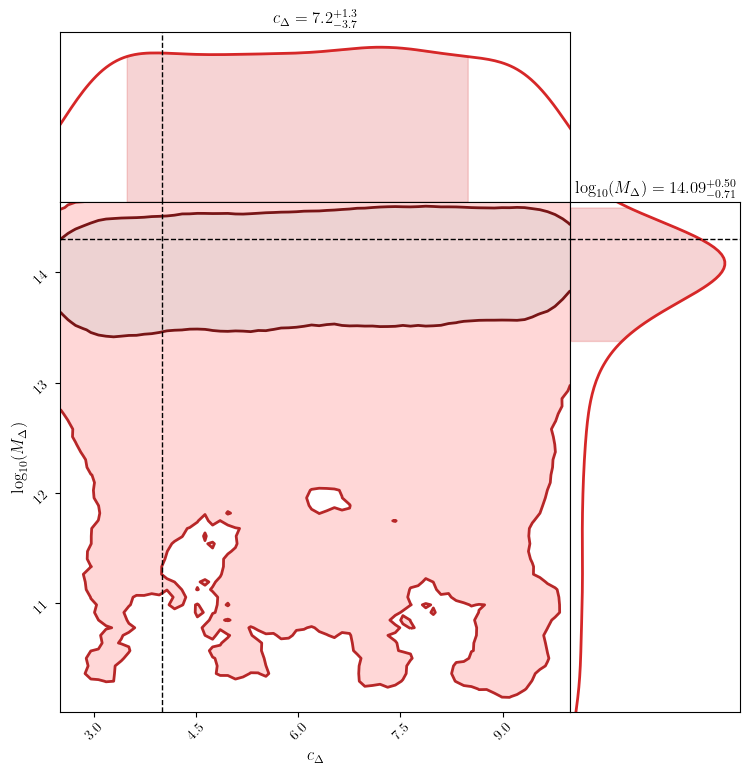

In [11]:
rows = np.array([mcat.peek_row(i).dup_array() for i in range(nwalkers * 400, mcat.len())])
params = ["$" + mcat.col_symb(i) + "$" for i in range (mcat.ncols())]

partial = ChainConsumer ()
partial.add_chain(rows[:,1:], parameters=params[1:], name=f"$\sigma_{{\epsilon^s}} = {sigma_g}$")
partial.configure(spacing=0.0, usetex=True, colors='#D62728', shade=True, shade_alpha=0.2, bar_shade=True, smooth=True, kde=True, legend_color_text=False, linewidths=2)

CC_fig = partial.plotter.plot(figsize=(8, 8), truth=[4, 14.301])

fig = plt.figure(num=CC_fig, figsize=(8,8), dpi=300, facecolor="white")